In [121]:
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
import json
import matplotlib.pyplot as plt
#import statsmodels.tsa.stattools as ts
from init_objects import *
from functions.stylizedfacts import *
from functions.helpers import organise_data
#from functions.evolutionaryalgo import quadratic_loss_function
from functions.inequality import gini, lorenz_curve
from distribution_model import *
import statsmodels.api as sm
from SALib.sample import latin
from matplotlib import style
from collections import OrderedDict
from functions.indirect_calibration import distr_model_performance
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
from functions.find_bubbles import *

In [2]:
style.use('ggplot')

In [3]:
NRUNS = 3

In [4]:
with open('parameters.json', 'r') as f:
    params = json.loads(f.read())

In [5]:
params['ticks'] = 4000
params['strat_share_chartists'] = 0.85

# Experiment 1 estimated parameters

In [6]:
trdrs = []
orbs = []
for seed in range(NRUNS): 
    traders, orderbook = init_objects_distr(params, seed)
    traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
    trdrs.append(traders)
    orbs.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  2


In [7]:
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(orbs)

In [8]:
wealth_starts = []
wealth_ends = []
ginis_ot = []
palmas_ot = []
twtws_ot = []
risk_aversions = []
horizons = []
learning_abilities = []
chartist_expectations = []
fundamentalist_expectations = []
profits = []

# determine the start and end wealth of the bubble
for seed, traders in enumerate(trdrs):
    money_start = np.array([x.var.money[0] for x in traders])
    stocks_start = np.array([x.var.stocks[0] for x in traders])
    wealth_start = money_start + (stocks_start * orbs[seed].tick_close_price[0])

    money_end = np.array([x.var.money[-1] for x in traders])
    stocks_end = np.array([x.var.stocks[-1] for x in traders])
    wealth_end = money_end + (stocks_end * orbs[seed].tick_close_price[-1])
    
    # profits
    profits.append((np.array(wealth_end) - np.array(wealth_start)) / np.array(wealth_start))

    # determine characteristics of the agents
    risk_aversions.append([x.par.risk_aversion for x in traders])
    horizons.append([x.par.horizon for x in traders])
    learning_abilities.append([x.par.learning_ability for x in traders])
    chartist_expectations.append([x.var.weight_chartist[: ] for x in traders])
    fundamentalist_expectations.append([x.var.weight_fundamentalist[:] for x in traders])

    wealth_gini_over_time = []
    palma_over_time = []
    twentytwenty_over_time = []
    for t in range(params['ticks']):
        money = np.array([x.var.money[t] for x in traders])
        stocks = np.array([x.var.stocks[t] for x in traders])
        wealth = money + (stocks * orbs[seed].tick_close_price[0])

        share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
        share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
        palma_over_time.append(share_top_10 / share_bottom_40)

        share_top_20 = np.mean(np.sort(wealth)[int(len(wealth) * 0.8):])
        share_bottom_20 = np.mean(np.sort(wealth)[:int(len(wealth) * 0.2)])
        twentytwenty_over_time.append(share_top_20 / share_bottom_20)

        wealth_gini_over_time.append(gini(wealth))

    wealth_starts.append(list(wealth_start))
    wealth_ends.append(list(wealth_end))
    ginis_ot.append(wealth_gini_over_time)
    palmas_ot.append(palma_over_time)
    twtws_ot.append(twentytwenty_over_time)

In [9]:
fundamentalist_component_at_t = 0
for x in trdrs[0]:
    fundamentalist_component_at_t += np.array(x.var.weight_fundamentalist)

In [10]:
fundamentalist_components = [np.array(x.var.weight_fundamentalist) for x in trdrs[0]]
chartist_components = [np.array(x.var.weight_chartist) for x in trdrs[0]]
random_components = [np.array(x.var.weight_random) for x in trdrs[0]]

In [11]:
fundamentalist_sentiment = sum(fundamentalist_components)
chartist_sentiment = sum(chartist_components)
random_sentiment = sum(random_components)
total_sentiment = fundamentalist_sentiment + chartist_sentiment + random_sentiment

In [12]:
all_profits = []
all_seeds = []
chart_exp = []
fund_exp = []
learn_ab = []
hors = []
rav = []
for idx, p in enumerate(profits):
    all_profits += list(p)
    learn_ab += learning_abilities[idx]
    hors += horizons[idx]
    rav += risk_aversions[idx]
    chart_exp += [np.mean(c_exp) for c_exp in chartist_expectations[idx]]
    fund_exp += [np.mean(f_exp) for f_exp in fundamentalist_expectations[idx]]
    all_seeds += [idx for c_exp in chartist_expectations[idx]]

In [13]:
redistr_df = pd.DataFrame({'wealth_change': all_profits, 'seed': all_seeds, 'risk_av': rav, 
              'horizon': hors, 'learning': learn_ab, 'chart_exp': chart_exp, 'fund_exp': fund_exp})
redistr_df['const'] = 1

## Experiment 2 only fundamentalists

In [14]:
params['strat_share_chartists'] = 0.0
params['fundamentalist_horizon_multiplier'] = 0.5
params['average_learning_ability'] = 0.0
params['mutation_intensity'] = 0.0

In [15]:
trdrs_f = []
orbs_f = []
for seed in range(NRUNS): 
    traders, orderbook = init_objects_distr(params, seed)
    traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
    trdrs_f.append(traders)
    orbs_f.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  2


In [16]:
mc_prices_f, mc_returns_f, mc_autocorr_returns_f, mc_autocorr_abs_returns_f, mc_volatility_f, mc_volume_f, mc_fundamentals_f = organise_data(orbs_f)

In [17]:
wealth_starts_f = []
wealth_ends_f = []
ginis_ot_f = []
palmas_ot_f = []
twtws_ot_f = []
risk_aversions_f = []
horizons_f = []
learning_abilities_f = []
chartist_expectations_f = []
fundamentalist_expectations_f = []
profits_f = []

# determine the start and end wealth of the bubble
for seed, traders in enumerate(trdrs_f):
    money_start = np.array([x.var.money[0] for x in traders])
    stocks_start = np.array([x.var.stocks[0] for x in traders])
    wealth_start = money_start + (stocks_start * orbs_f[seed].tick_close_price[0])

    money_end = np.array([x.var.money[-1] for x in traders])
    stocks_end = np.array([x.var.stocks[-1] for x in traders])
    wealth_end = money_end + (stocks_end * orbs_f[seed].tick_close_price[-1])
    
    # profits
    profits_f.append((np.array(wealth_end) - np.array(wealth_start)) / np.array(wealth_start))

    # determine characteristics of the agents
    risk_aversions_f.append([x.par.risk_aversion for x in traders])
    horizons_f.append([x.par.horizon for x in traders])
    learning_abilities_f.append([x.par.learning_ability for x in traders])
    chartist_expectations_f.append([x.var.weight_chartist[: ] for x in traders])
    fundamentalist_expectations_f.append([x.var.weight_fundamentalist[:] for x in traders])

    wealth_gini_over_time = []
    palma_over_time = []
    twentytwenty_over_time = []
    for t in range(params['ticks']):
        money = np.array([x.var.money[t] for x in traders])
        stocks = np.array([x.var.stocks[t] for x in traders])
        wealth = money + (stocks * orbs_f[0].tick_close_price[t])

        share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
        share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
        palma_over_time.append(share_top_10 / share_bottom_40)

        share_top_20 = np.mean(np.sort(wealth)[int(len(wealth) * 0.8):])
        share_bottom_20 = np.mean(np.sort(wealth)[:int(len(wealth) * 0.2)])
        twentytwenty_over_time.append(share_top_20 / share_bottom_20)

        wealth_gini_over_time.append(gini(wealth))

    wealth_starts_f.append(list(wealth_start))
    wealth_ends_f.append(list(wealth_end))
    ginis_ot_f.append(wealth_gini_over_time)
    palmas_ot_f.append(palma_over_time)
    twtws_ot_f.append(twentytwenty_over_time)

In [18]:
fundamentalist_component_at_t = 0
for x in trdrs_f[0]:
    fundamentalist_component_at_t += np.array(x.var.weight_fundamentalist)

In [19]:
fundamentalist_components = [np.array(x.var.weight_fundamentalist) for x in trdrs_f[0]]
chartist_components = [np.array(x.var.weight_chartist) for x in trdrs_f[0]]
random_components = [np.array(x.var.weight_random) for x in trdrs_f[0]]
fundamentalist_sentiment_f = sum(fundamentalist_components)
chartist_sentiment_f = sum(chartist_components)
random_sentiment_f = sum(random_components)
total_sentiment_f = fundamentalist_sentiment + chartist_sentiment + random_sentiment

In [20]:
all_profits_f = []
all_seeds_f = []
chart_exp_f = []
fund_exp_f = []
learn_ab_f = []
hors_f = []
rav_f = []
for idx, p in enumerate(profits_f):
    all_profits_f += list(p)
    learn_ab_f += learning_abilities_f[idx]
    hors_f += horizons_f[idx]
    rav_f += risk_aversions_f[idx]
    chart_exp_f += [np.mean(c_exp) for c_exp in chartist_expectations_f[idx]]
    fund_exp_f += [np.mean(f_exp) for f_exp in fundamentalist_expectations_f[idx]]
    all_seeds_f += [idx for c_exp in chartist_expectations_f[idx]]

In [21]:
redistr_df_f = pd.DataFrame({'wealth_change': all_profits_f, 'seed': all_seeds_f, 'risk_av': rav_f, 
              'horizon': hors_f, 'learning': learn_ab_f, 'chart_exp': chart_exp_f, 'fund_exp': fund_exp_f})
redistr_df_f['const'] = 1

# Experiment 3: No borrowing constraints

In [22]:
from no_stocks_distribution_model import *

In [33]:
with open('parameters.json', 'r') as f:
    params = json.loads(f.read())
    
params['ticks'] = 4000
params['strat_share_chartists'] = 0.75
params['fundamentalist_horizon_multiplier'] = 0.5
params['average_learning_ability'] = 0.0
params['mutation_intensity'] = 0.0

In [24]:
trdrs_ns = []
orbs_ns = []
for seed in range(NRUNS): 
    traders, orderbook = init_objects_distr(params, seed)
    traders, orderbook = pb_distr_model_no_stocks(traders, orderbook, params, seed)
    trdrs_ns.append(traders)
    orbs_ns.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  2


In [25]:
mc_prices_ns, mc_returns_ns, mc_autocorr_returns_ns, mc_autocorr_abs_returns_ns, mc_volatility_ns, mc_volume_ns, mc_fundamentals_ns = organise_data(orbs_ns)

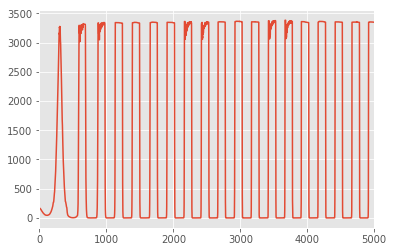

In [26]:
mc_prices_ns[0].plot()

In [27]:
wealth_starts_ns = []
wealth_ends_ns = []
ginis_ot_ns = []
palmas_ot_ns = []
twtws_ot_ns = []
risk_aversions_ns = []
horizons_ns = []
learning_abilities_ns = []
chartist_expectations_ns = []
fundamentalist_expectations_ns = []
profits_ns = []

# determine the start and end wealth of the bubble
for seed, traders in enumerate(trdrs_ns):
    money_start = np.array([x.var.money[0] for x in traders])
    stocks_start = np.array([x.var.stocks[0] for x in traders])
    wealth_start = money_start + (stocks_start * orbs_ns[seed].tick_close_price[0])

    money_end = np.array([x.var.money[-1] for x in traders])
    stocks_end = np.array([x.var.stocks[-1] for x in traders])
    wealth_end = money_end + (stocks_end * orbs_ns[seed].tick_close_price[-1])
    
    # profits
    profits_ns.append((np.array(wealth_end) - np.array(wealth_start)) / np.array(wealth_start))

    # determine characteristics of the agents
    risk_aversions_ns.append([x.par.risk_aversion for x in traders])
    horizons_ns.append([x.par.horizon for x in traders])
    learning_abilities_ns.append([x.par.learning_ability for x in traders])
    chartist_expectations_ns.append([x.var.weight_chartist[: ] for x in traders])
    fundamentalist_expectations_ns.append([x.var.weight_fundamentalist[:] for x in traders])

    wealth_gini_over_time = []
    palma_over_time = []
    twentytwenty_over_time = []
    for t in range(params['ticks']):
        money = np.array([x.var.money[t] for x in traders])
        stocks = np.array([x.var.stocks[t] for x in traders])
        wealth = money + (stocks * orbs_ns[0].tick_close_price[t])

        share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
        share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
        palma_over_time.append(share_top_10 / share_bottom_40)

        share_top_20 = np.mean(np.sort(wealth)[int(len(wealth) * 0.8):])
        share_bottom_20 = np.mean(np.sort(wealth)[:int(len(wealth) * 0.2)])
        twentytwenty_over_time.append(share_top_20 / share_bottom_20)

        wealth_gini_over_time.append(gini(wealth))

    wealth_starts_ns.append(list(wealth_start))
    wealth_ends_ns.append(list(wealth_end))
    ginis_ot_ns.append(wealth_gini_over_time)
    palmas_ot_ns.append(palma_over_time)
    twtws_ot_ns.append(twentytwenty_over_time)

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calc

In [28]:
fundamentalist_component_at_t = 0
for x in trdrs_ns[0]:
    fundamentalist_component_at_t += np.array(x.var.weight_fundamentalist)

In [29]:
fundamentalist_components = [np.array(x.var.weight_fundamentalist) for x in trdrs_ns[0]]
chartist_components = [np.array(x.var.weight_chartist) for x in trdrs_ns[0]]
random_components = [np.array(x.var.weight_random) for x in trdrs_ns[0]]
fundamentalist_sentiment_ns = sum(fundamentalist_components)
chartist_sentiment_ns = sum(chartist_components)
random_sentiment_ns = sum(random_components)
total_sentiment_ns = fundamentalist_sentiment_ns + chartist_sentiment_ns + random_sentiment_ns

In [30]:
all_profits_ns = []
all_seeds_ns = []
chart_exp_ns = []
fund_exp_ns = []
learn_ab_ns = []
hors_ns = []
rav_ns = []
for idx, p in enumerate(profits_ns):
    all_profits_ns += list(p)
    learn_ab_ns += learning_abilities_ns[idx]
    hors_ns += horizons_ns[idx]
    rav_ns += risk_aversions_ns[idx]
    chart_exp_ns += [np.mean(c_exp) for c_exp in chartist_expectations_ns[idx]]
    fund_exp_ns += [np.mean(f_exp) for f_exp in fundamentalist_expectations_ns[idx]]
    all_seeds_ns += [idx for c_exp in chartist_expectations_ns[idx]]

In [31]:
redistr_df_ns = pd.DataFrame({'wealth_change': all_profits_ns, 'seed': all_seeds_ns, 'risk_av': rav_ns, 
              'horizon': hors_ns, 'learning': learn_ab_ns, 'chart_exp': chart_exp_ns, 'fund_exp': fund_exp_ns})
redistr_df_ns['const'] = 1

# Picture:

Prices, sentiment, inequality. 



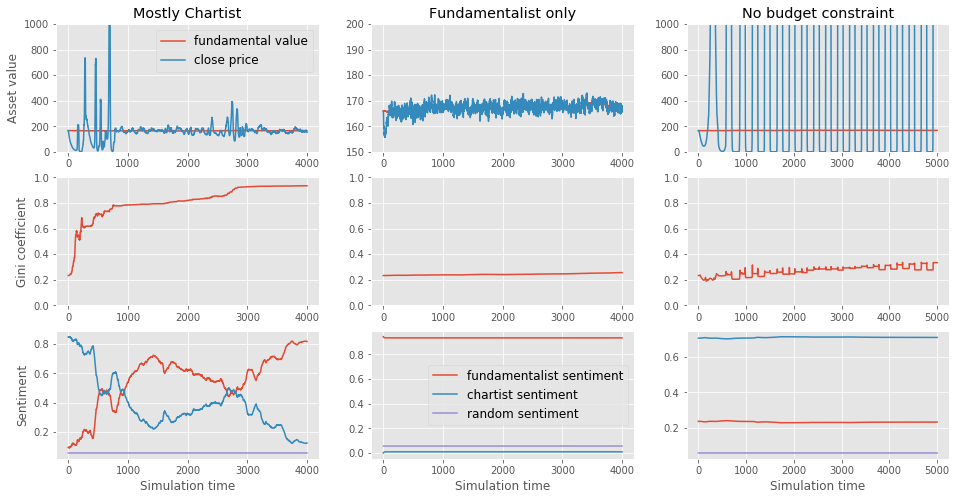

In [32]:
fig, ((ax1, ax2, ax_ns1), (ax3, ax4, ax_ns2), (ax5, ax6, ax_ns3)) = plt.subplots(3, 3, figsize=[16,8])

ax1.plot(mc_fundamentals.index, mc_fundamentals[0], label='fundamental value')
ax1.plot(mc_prices.index, mc_prices[0], label='close price')
ax1.set_ylim(0,1000)
ax1.legend(loc='best', fontsize='12')

ax2.plot(mc_fundamentals.index, mc_fundamentals_f[0], label='fundamental value')
ax2.plot(mc_prices.index, mc_prices_f[0], label='close price')
ax2.set_ylim(150,200)

ax_ns1.plot(mc_fundamentals_ns.index, mc_fundamentals_ns[0], label='fundamental value')
ax_ns1.plot(mc_prices_ns.index, mc_prices_ns[0], label='close price')
ax_ns1.set_ylim(0,1000)

ax3.plot(range(len(ginis_ot[0])), ginis_ot[0])
ax3.set_ylim(0, 1)
ax4.plot(range(len(ginis_ot_f[0])), ginis_ot_f[0])
ax4.set_ylim(0, 1)

ax_ns2.plot(range(len(ginis_ot_ns[0])), ginis_ot_ns[0])
ax_ns2.set_ylim(0, 1)

ax5.plot(range(len(fundamentalist_sentiment)), fundamentalist_sentiment / total_sentiment, label='fundamentalist sentiment')
ax5.plot(range(len(chartist_sentiment)), chartist_sentiment / total_sentiment, label='chartist sentiment')
ax5.plot(range(len(random_sentiment)), random_sentiment / total_sentiment, label='random sentiment')


ax6.plot(range(len(fundamentalist_sentiment_f)), fundamentalist_sentiment_f / total_sentiment_f, label='fundamentalist sentiment')
ax6.plot(range(len(chartist_sentiment_f)), chartist_sentiment_f / total_sentiment_f, label='chartist sentiment')
ax6.plot(range(len(random_sentiment_f)), random_sentiment_f / total_sentiment_f, label='random sentiment')
ax6.legend(loc='best', fontsize='12')

ax_ns3.plot(range(len(fundamentalist_sentiment_ns)), fundamentalist_sentiment_ns / total_sentiment_ns, label='fundamentalist sentiment')
ax_ns3.plot(range(len(chartist_sentiment_ns)), chartist_sentiment_ns / total_sentiment_ns, label='chartist sentiment')
ax_ns3.plot(range(len(random_sentiment_ns)), random_sentiment_ns / total_sentiment_ns, label='random sentiment')

ax1.set_title('Mostly Chartist')
ax2.set_title('Fundamentalist only')
ax_ns1.set_title('No budget constraint')

ax1.set_ylabel('Asset value')
ax3.set_ylabel('Gini coefficient')
ax5.set_ylabel('Sentiment')

for ax in [ax5, ax6, ax_ns3]:
    ax.set_xlabel('Simulation time')

fig.savefig('long_series_inequality.png')

# Regression

inequality = $\alpha$ + time + chartist_dummy + chartist_no_budget_dummy

In [34]:
from linearmodels import PanelOLS
from linearmodels import RandomEffects

In [ ]:
# construct data:

# Gini, palma, twtw, time, seed, dummy for model type

In [112]:
# get all ginis 
ginis_ot_all_seeds = []
palmas_ot_all_seeds = []
twtws_ot_all_seeds = []
times = []
seeds = []
dummies = []
    
f_ginis_ot_all_seeds = []
f_palmas_ot_all_seeds = []
f_twtws_ot_all_seeds = []
counter = 1
for g, p, t in ginis_ot_f, palmas_ot_f, twtws_ot_f:
    f_ginis_ot_all_seeds += g
    f_palmas_ot_all_seeds += p
    f_twtws_ot_all_seeds += t
    times += [x for x in range(len(g))]
    seeds += [counter for x in range(len(g))]
    dummies += ['fund' for x in range(len(g))]
    counter += 1
    
counter = 1
for g, p, t in ginis_ot, palmas_ot, twtws_ot:
    ginis_ot_all_seeds += g
    palmas_ot_all_seeds += p
    twtws_ot_all_seeds += t
    times += [x for x in range(len(g))]
    seeds += [counter for x in range(len(g))]
    dummies += ['w_chart' for x in range(len(g))]
    counter += 1
    
ns_ginis_ot_all_seeds = []
ns_palmas_ot_all_seeds = []
ns_twtws_ot_all_seeds = []
counter = 1
for g, p, t in ginis_ot_ns, palmas_ot_ns, twtws_ot_ns:
    ns_ginis_ot_all_seeds += g
    ns_palmas_ot_all_seeds += p
    ns_twtws_ot_all_seeds += t
    times += [x for x in range(len(g))]
    seeds += [counter for x in range(len(g))]
    dummies += ['no_stocks' for x in range(len(g))]
    counter += 1

In [122]:
re_data = pd.DataFrame({'gini': ginis_ot_all_seeds + f_ginis_ot_all_seeds + ns_ginis_ot_all_seeds,
             'palma': palmas_ot_all_seeds + f_palmas_ot_all_seeds + ns_palmas_ot_all_seeds,
             'twtw': twtws_ot_all_seeds + f_twtws_ot_all_seeds + ns_twtws_ot_all_seeds,
             'time': times, 'seed': seeds, 'experiment': dummies})

In [123]:
# create dummies 
re_data = pd.get_dummies(re_data, columns = ['experiment'], drop_first=True)

In [115]:
#re_data = re_data.set_index(['time', 'seed'])

In [124]:
re_data.head(2)

,gini,palma,twtw,time,seed,experiment_no_stocks,experiment_w_chart
0,0.232774,0.241465,0.234376,0,1,0,0
1,0.232814,0.241481,0.234398,1,1,0,0


In [125]:
exog = sm.add_constant(re_data[['experiment_no_stocks', 'experiment_w_chart']])
gini_re_res = RandomEffects(re_data.gini, exog).fit()
palma_re_res = RandomEffects(re_data.palma, exog).fit()
twtw_re_res = RandomEffects(re_data.twtw, exog).fit()

In [133]:
ginis_res = smf.mixedlm("gini ~ time + experiment_w_chart + experiment_no_stocks", re_data, groups=re_data["seed"]).fit()

print(ginis_res.summary())

               Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    gini        
No. Observations:     39000      Method:                REML        
No. Groups:           3          Scale:                 1422.6841   
Min. group size:      13000      Likelihood:            -196929.0312
Max. group size:      13000      Converged:             Yes         
Mean group size:      13000.0                                       
--------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept             37.815   11.122    3.400 0.001  16.017  59.613
time                   0.008    0.000   50.433 0.000   0.007   0.008
experiment_w_chart   -51.290    0.487 -105.330 0.000 -52.244 -50.335
experiment_no_stocks -57.346    0.468 -122.535 0.000 -58.264 -56.429
Group Var            370.455   10.236             

Text(0.5, 0, 'fund_exp')

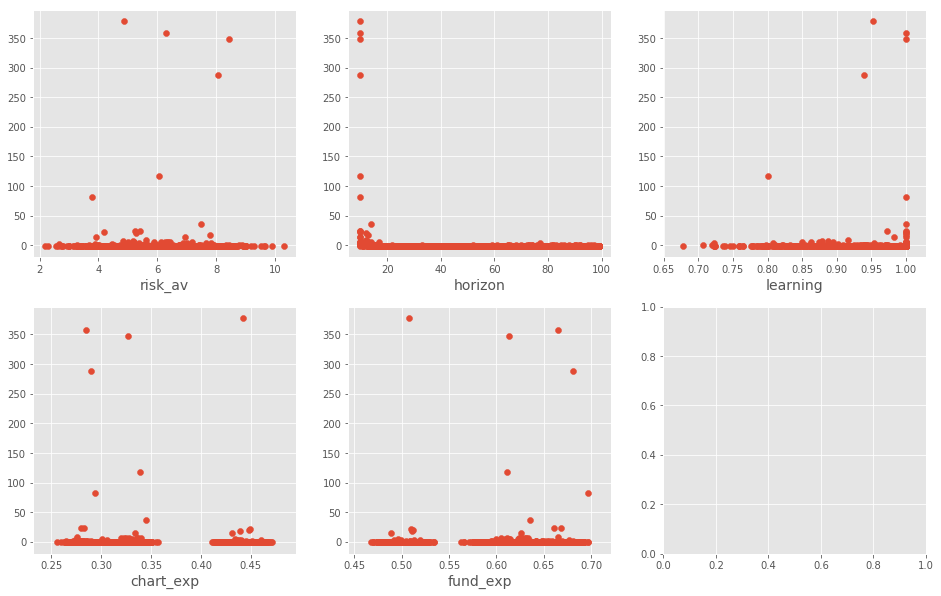

In [108]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=[16,10])

ax1.scatter(redistr_df['risk_av'], redistr_df['wealth_change'])
ax2.scatter(redistr_df['horizon'], redistr_df['wealth_change'])
ax3.scatter(redistr_df['learning'], redistr_df['wealth_change'])
ax4.scatter(redistr_df['chart_exp'], redistr_df['wealth_change'])
ax5.scatter(redistr_df['fund_exp'], redistr_df['wealth_change'])

ax1.set_xlabel('risk_av', fontsize=14)
ax2.set_xlabel('horizon', fontsize=14)
ax3.set_xlabel('learning', fontsize=14)
ax4.set_xlabel('chart_exp', fontsize=14)
ax5.set_xlabel('fund_exp', fontsize=14)

Text(0.5, 0, 'fund_exp')

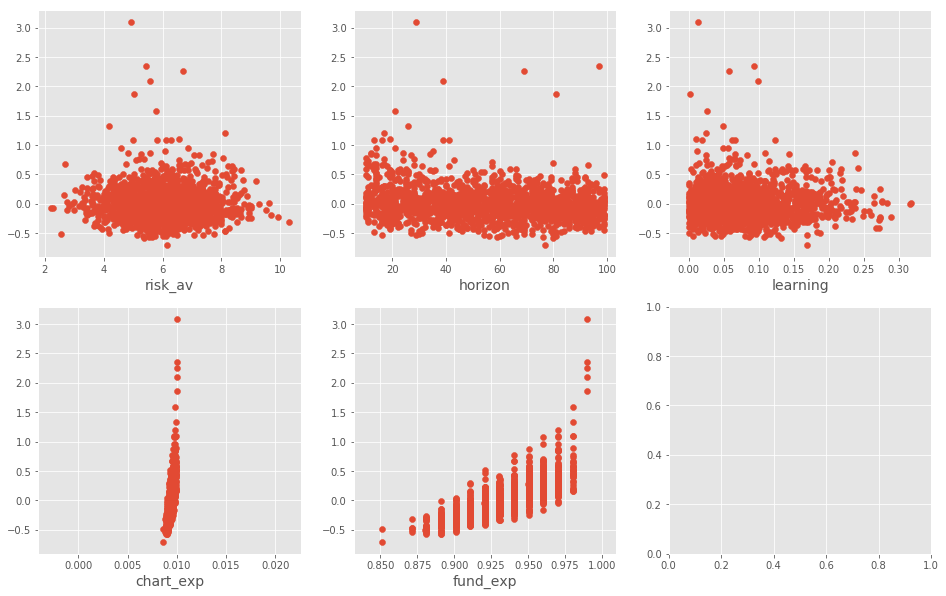

In [96]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=[16,10])

ax1.scatter(redistr_df_f['risk_av'], redistr_df_f['wealth_change'])
ax2.scatter(redistr_df_f['horizon'], redistr_df_f['wealth_change'])
ax3.scatter(redistr_df_f['learning'], redistr_df_f['wealth_change'])
ax4.scatter(redistr_df_f['chart_exp'], redistr_df_f['wealth_change'])
ax5.scatter(redistr_df_f['fund_exp'], redistr_df_f['wealth_change'])

ax1.set_xlabel('risk_av', fontsize=14)
ax2.set_xlabel('horizon', fontsize=14)
ax3.set_xlabel('learning', fontsize=14)
ax4.set_xlabel('chart_exp', fontsize=14)
ax5.set_xlabel('fund_exp', fontsize=14)

Text(0.5, 0, 'fund_exp')

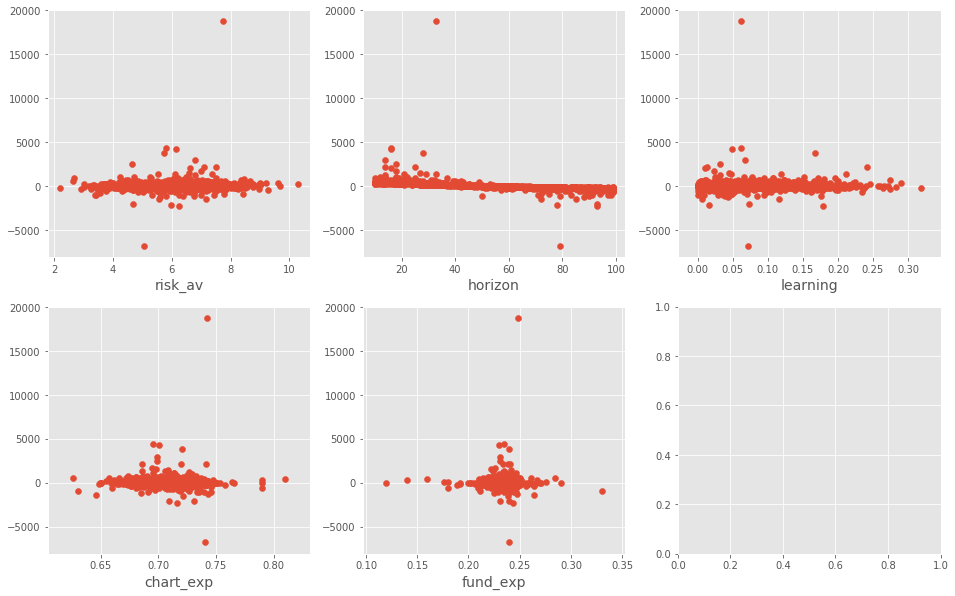

In [49]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=[16,10])

ax1.scatter(redistr_df_ns['risk_av'], redistr_df_ns['wealth_change'])
ax2.scatter(redistr_df_ns['horizon'], redistr_df_ns['wealth_change'])
ax3.scatter(redistr_df_ns['learning'], redistr_df_ns['wealth_change'])
ax4.scatter(redistr_df_ns['chart_exp'], redistr_df_ns['wealth_change'])
ax5.scatter(redistr_df_ns['fund_exp'], redistr_df_ns['wealth_change'])

ax1.set_xlabel('risk_av', fontsize=14)
ax2.set_xlabel('horizon', fontsize=14)
ax3.set_xlabel('learning', fontsize=14)
ax4.set_xlabel('chart_exp', fontsize=14)
ax5.set_xlabel('fund_exp', fontsize=14)